# PHASE_5_CAPSTONE_PROJECT

# MODELING

## Siamese neutral network

In [15]:
import pandas as pd
import numpy as np
import csv
import json
import glob
import os
import cv2
import shutil
import random
import pickle
import h5py
import hdf5storage
from PIL import Image
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from IPython.display import display
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras import layers
from keras.models import Sequential
from keras.layers import Reshape


from tensorflow.keras.layers import Dense # creates densely connected layer object
from tensorflow.keras.layers import Flatten # takes 2D input and turns into 1D array
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from keras.models import load_model


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# a new layer that rescales/normalizes the activations after each layer.
# has a weak regularization effect. also allows 

from keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Resizing, RandomFlip, RandomRotation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50

%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'

image_size = (256, 256)
num_classes = 10

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
 
val_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the val set

test_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the test set


train_generator = train_datagen.flow_from_directory(directory=train_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=64,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator = val_datagen.flow_from_directory(directory=val_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=64,
                                                shuffle=True,
                                                  classes=[str(i) for i in range(num_classes)])

test_generator = test_datagen.flow_from_directory(directory=test_data_dir, target_size = image_size,
                                                    class_mode='categorical',
                                                   batch_size=64,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])

Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


#### Create positive and negative pairs.

In [3]:
def create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch):
    pairs = []
    labels = []

    for _ in range(num_pairs_per_batch):
        # Generate a batch of images and their corresponding labels
        batch_images, batch_labels = data_generator.next()

        # Split the batch into two halves (left and right images)
        batch_size = len(batch_images)
        half_batch_size = batch_size // 2
        left_images = batch_images[:half_batch_size]
        right_images = batch_images[half_batch_size:]

        # Create positive and negative pairs within the batch
        for i in range(half_batch_size):
            img1 = left_images[i]
            img2 = right_images[i]
            label1 = batch_labels[i]
            label2 = batch_labels[i + half_batch_size]

            # Determine if the images belong to the same class (positive pair) or different classes (negative pair)
            same_class = np.random.randint(0, 2)
            if same_class == 1:
                label = 1  # Positive pair
            else:
                label = 0  # Negative pair

            pairs.append([img1, img2])
            labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels


#### Loss function

In [4]:


def contrastive_loss(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


#### Define Euclidean distance function

In [19]:
def euclid_dis(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=-1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [7]:
def base_model(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)(input)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    model = tf.keras.Model(inputs=input, outputs=x)
#     model = tf.keras.Model(inputs=input, outputs=output) #Same with above line
    return model

In [8]:
def create_siamese_model(base_model, input_shape):
    # Input for left and right image vectors
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Pass the left and right inputs through the base model
    left_output = base_model(left_input)
    right_output = base_model(right_input)

    # Calculate the Euclidean distance between the two outputs
    distance = Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([left_output, right_output])

    # Create the Siamese model
    siamese_model = Model(inputs=[left_input, right_input], outputs=distance)
#     siamese_model = Model(inputs=[left_input, right_input], outputs=distance) # Same with above line

    return siamese_model

In [8]:
base_network = base_model((256,256,3))

In [9]:
siamese_model2 = create_siamese_model(base_network,(256,256,3))

In [10]:
siamese_model2.compile(loss=contrastive_loss,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

During the input calculation step, we will narrow the scope of the training and validation sets. Besides, the number of pairs trained each time will be determined by the batch size.

In [11]:
# Define the batch size and number of pairs per batch
batch_size = 64
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.05

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

The input above will be fit into the model.

In [12]:
history_siamese_model2 = siamese_model2.fit(
    custom_data_generator(train_generator, num_classes, num_pairs_per_batch),
    steps_per_epoch=train_num_batches_per_epoch,
    validation_data=custom_data_generator(val_generator, num_classes, num_pairs_per_batch),
    validation_steps=val_num_batches_per_epoch,  
    epochs=20
)

Epoch 1/20
11/11 [==============================] - 1248s 114s/step - loss: 0.4795 - accuracy: 0.4995 - auc: 0.4963 - precision: 0.4860 - recall: 0.2759 - val_loss: 0.2954 - val_accuracy: 0.5143 - val_auc: 0.5059 - val_precision: 0.4973 - val_recall: 0.3770
Epoch 2/20
11/11 [==============================] - 1216s 111s/step - loss: 0.2750 - accuracy: 0.5042 - auc: 0.4964 - precision: 0.5127 - recall: 0.3887 - val_loss: 0.2760 - val_accuracy: 0.4936 - val_auc: 0.4937 - val_precision: 0.4800 - val_recall: 0.4191
Epoch 3/20
11/11 [==============================] - 1146s 105s/step - loss: 0.2670 - accuracy: 0.4999 - auc: 0.5004 - precision: 0.4975 - recall: 0.3520 - val_loss: 0.2711 - val_accuracy: 0.5235 - val_auc: 0.5155 - val_precision: 0.5413 - val_recall: 0.2141
Epoch 4/20
11/11 [==============================] - 1148s 104s/step - loss: 0.2674 - accuracy: 0.4964 - auc: 0.5046 - precision: 0.5002 - recall: 0.3990 - val_loss: 0.2725 - val_accuracy: 0.5038 - val_auc: 0.5030 - val_precisi

#### Save model and history

In [13]:
siamese_model2.save('siamese_model2_20epoch.h5')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
hdf5storage.savemat("history_siamese_model2_20epoch.h5", history_siamese_model2.history)

#### Load the model and history

In [370]:
siamese_model_loaded = load_model('siamese_model2_5epoch.h5', custom_objects={'contrastive_loss': contrastive_loss})

In [371]:
siamese_model_loaded.evaluate(
    custom_data_generator(train_generator, num_classes, num_pairs_per_batch),
    steps=train_num_batches_per_epoch)

11/11 [==============================] - 209s 19s/step - loss: 0.2656 - accuracy: 0.4927 - auc: 0.4863 - precision: 0.4896 - recall: 0.4469


[0.26563766598701477,
 0.4927188754081726,
 0.4863257110118866,
 0.4896443784236908,
 0.4469413161277771]

In [372]:
siamese_model_loaded.evaluate(
    custom_data_generator(test_generator, num_classes, num_pairs_per_batch),
    steps=test_num_batches_per_epoch)

3/3 [==============================] - 56s 18s/step - loss: 0.2852 - accuracy: 0.5060 - auc: 0.4989 - precision: 0.5202 - recall: 0.2419


[0.285208135843277,
 0.5060241222381592,
 0.498872846364975,
 0.5201668739318848,
 0.24191461503505707]

In [373]:
siamese_model_loaded.evaluate(
    custom_data_generator(test_generator, num_classes, num_pairs_per_batch),
    steps=len(test_generator))

77/77 [==============================] - 1382s 18s/step - loss: 0.2879 - accuracy: 0.4998 - auc: 0.5002 - precision: 0.4996 - recall: 0.2057


[0.2879106104373932,
 0.4997716248035431,
 0.5002148747444153,
 0.4996301829814911,
 0.20566296577453613]

In [375]:
history_siamese_model_loaded= hdf5storage.loadmat("history_siamese_model2_5epoch.h5",custom_objects={'contrastive_loss': contrastive_loss})

In [376]:
print(history_siamese_model_loaded.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


#### Analyze the model why accuracy stuck at 50%

In [377]:
train_pairs,train_labels = create_siamese_pairs(train_generator, num_classes, 32)

In [378]:
train_pairs.shape

(1024, 2, 256, 256, 3)

In [379]:
train_labels.shape

(1024,)

#### Calculate Euclidean distance

In [380]:
# Evaluate on the test set
test_pairs, test_labels = create_siamese_pairs(test_generator, num_classes, len(test_generator))
siamese_model_predictions = siamese_model_loaded.predict([test_pairs[:, 0], test_pairs[:, 1]])

77/77 [==============================] - 29s 378ms/step


In [381]:
test_pairs.shape

(2463, 2, 256, 256, 3)

In [382]:
test_labels.shape

(2463,)

In [383]:
siamese_model_predictions

array([[0.34381258],
       [0.2551574 ],
       [0.16073889],
       ...,
       [0.12821534],
       [0.30256435],
       [0.3077003 ]], dtype=float32)

In [384]:
euclidean_distances = np.squeeze(siamese_model_predictions)
euclidean_distances

array([0.34381258, 0.2551574 , 0.16073889, ..., 0.12821534, 0.30256435,
       0.3077003 ], dtype=float32)

In [385]:
euclidean_distances.shape

(2463,)

In [386]:
sorted_indices = np.argsort(euclidean_distances)
sorted_indices

array([187, 147, 112, ..., 418, 594, 270])

In [388]:
euclidean_distances.min()

0.030816033

In [389]:
top_5_indices = sorted_indices[:5]
top_5_indices

array([187, 147, 112,  45,  50])

In [390]:
for i in range(5):
    print(f"Pair {i+1}: Distance: {euclidean_distances[top_5_indices[i]]}")

Pair 1: Distance: 0.030816033482551575
Pair 2: Distance: 0.03449200466275215
Pair 3: Distance: 0.05293644592165947
Pair 4: Distance: 0.06082938611507416
Pair 5: Distance: 0.06489071995019913


In [391]:
top_5_pairs = test_pairs[top_5_indices]
top_5_pairs

array([[[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         ...,

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[1., 1.

#### Test to calcuate the Euclidean distance between 2 random loaded images

##### Test 1: Testing the distance between the same image with different names.

In [394]:
# Load the two identical images
image1_path = '/Users/thaophan/Documents/Flatiron/Phase5_Project/images256x256/1_test.jpg'
image2_path = '/Users/thaophan/Documents/Flatiron/Phase5_Project/images256x256/1537.jpg'

# Preprocess the images
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img /= 255.0  # Rescale the pixel values to [0, 1]
    return img

image_size = (256, 256)  # Set the same image size used in the model
image1 = preprocess_image(image1_path, target_size=image_size)
image2 = preprocess_image(image2_path, target_size=image_size)

# Expand dimensions to create batches (batch size = 1)
image1_batch = np.expand_dims(image1, axis=0)
image2_batch = np.expand_dims(image2, axis=0)

# Calculate the distance between the two images
pred_identical = siamese_model_loaded.predict([image1_batch, image2_batch])
distance_pred_identical = pred_identical[0][0]
distance_pred_identical

1/1 [==============================] - 0s 30ms/step


0.00031622776

The Euclidean distance between the two images is 0.00031623, indicating that they are nearly identical.

##### Test 2: Testing the distance between the two difference images

In [395]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the two random images
image1_path = '/Users/thaophan/Documents/Flatiron/Phase5_Project/images256x256/1635.jpg'
image2_path = '/Users/thaophan/Documents/Flatiron/Phase5_Project/images256x256/1537.jpg'

# Preprocess the images
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img /= 255.0  # Rescale the pixel values to [0, 1]
    return img

image_size = (256, 256)  # Set the same image size used in the model
image1 = preprocess_image(image1_path, target_size=image_size)
image2 = preprocess_image(image2_path, target_size=image_size)

# Expand dimensions to create batches (batch size = 1)
image1_batch = np.expand_dims(image1, axis=0)
image2_batch = np.expand_dims(image2, axis=0)

# Calculate the distance between the two images
predictions = siamese_model_loaded.predict([image1_batch, image2_batch])
distance_pred = predictions[0][0]
print("Euclidean Distance:", distance_pred)

1/1 [==============================] - 0s 26ms/step
Euclidean Distance: 0.541965


#### Test 3: Test the similarity of 1 images with all images in the test set and get the top 5 similar images

In [400]:
def preprocess_image(img_path, target_size):
    img = Image.open(img_path).resize(target_size)
    img = image.img_to_array(img)
    img /= 255.0  # Rescale the pixel values to [0, 1]
    return img


In [401]:
def calculate_euclidean_distance(image1_path, image2_paths, target_size):
    image1_batch = preprocess_image(image1_path, target_size)
    image1_batch = np.expand_dims(image1_batch, axis=0)

    distances = []
    for image2_path in image2_paths: 
        if not image2_path.endswith('.DS_Store'):  # Skip .DS_Store files
            image2_batch = preprocess_image(image2_path, target_size)
            image2_batch = np.expand_dims(image2_batch, axis=0)
            distance = siamese_model_loaded.predict([image1_batch, image2_batch])
            distances.append(distance)

    return distances


In [402]:
# Test data directory path
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Train_Test_Validation/Test'

# List to store image paths
all_image_paths = []

# Loop through all the classes in the test data directory
for class_name in os.listdir(test_data_dir):
    # Ignore the .DS_Store file
    if class_name == '.DS_Store':
        continue

    class_dir = os.path.join(test_data_dir, class_name)

    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Loop through all images in the class folder and get their paths
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            all_image_paths.append(image_path)


In [409]:
# Load the two random images
target_size = (256,256)
image1_path = '/Users/thaophan/Documents/Flatiron/Phase5_Project/images256x256/1635.jpg'
image2_paths = all_image_paths

In [410]:
distance_list = calculate_euclidean_distance(image1_path,image2_paths,target_size)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


In [411]:
distance_list

[array([[0.5397957]], dtype=float32),
 array([[0.4921231]], dtype=float32),
 array([[0.33910042]], dtype=float32),
 array([[0.6455883]], dtype=float32),
 array([[0.38952687]], dtype=float32),
 array([[0.39106372]], dtype=float32),
 array([[0.6164964]], dtype=float32),
 array([[0.4642812]], dtype=float32),
 array([[0.43478465]], dtype=float32),
 array([[0.5401508]], dtype=float32),
 array([[0.45891905]], dtype=float32),
 array([[0.39922363]], dtype=float32),
 array([[0.5274778]], dtype=float32),
 array([[0.5069797]], dtype=float32),
 array([[0.50479686]], dtype=float32),
 array([[0.61980844]], dtype=float32),
 array([[0.53792316]], dtype=float32),
 array([[0.6468706]], dtype=float32),
 array([[0.47959548]], dtype=float32),
 array([[0.4353805]], dtype=float32),
 array([[0.42828172]], dtype=float32),
 array([[0.69071716]], dtype=float32),
 array([[0.498771]], dtype=float32),
 array([[0.44536427]], dtype=float32),
 array([[0.5485519]], dtype=float32),
 array([[0.44410035]], dtype=float32),

In [412]:
# Convert distance_list to a numpy array
distances = np.array(distance_list)

# Flatten the array to remove the extra dimension
distances = distances.flatten()

# Get the indices of the top 5 smallest distances
top_5_indices = np.argsort(distances)[:5]

# Extract the top 5 smallest distances using the indices
top_5_smallest_distances = distances[top_5_indices]

print(top_5_smallest_distances)


[0.08545569 0.08897714 0.0935538  0.10193142 0.10336784]


In [413]:
# Assuming you have already obtained the distances and top_5 as shown in the previous code

# Convert top_5_indices to a list
top_5_indices_list = top_5_indices.tolist()

# Get the paths of the top 5 most similar images
top_5_similar_images = [image2_paths[i] for i in top_5_indices_list]

# Print the paths of the top 5 most similar images
print("Top 5 most similar images:")
for image_path in top_5_similar_images:
    print(image_path)


Top 5 most similar images:
/Users/thaophan/Documents/Flatiron/Phase5_Project/Train_Test_Validation/Test/7/59212.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Train_Test_Validation/Test/2/5924.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Train_Test_Validation/Test/7/45816.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Train_Test_Validation/Test/4/26449.jpg
/Users/thaophan/Documents/Flatiron/Phase5_Project/Train_Test_Validation/Test/7/54103.jpg


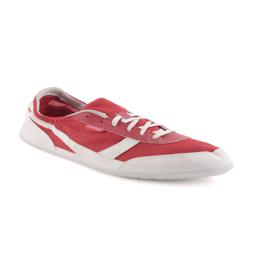

In [414]:
# Display the loaded image:
image1 = Image.open(image1_path)
display(image1)

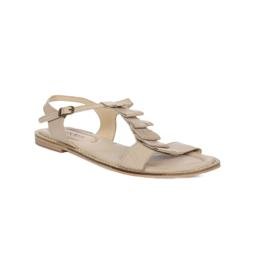

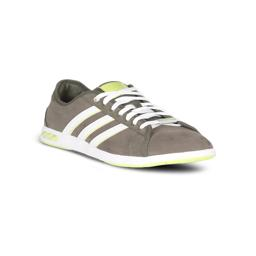

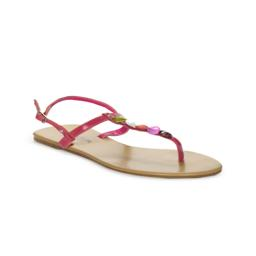

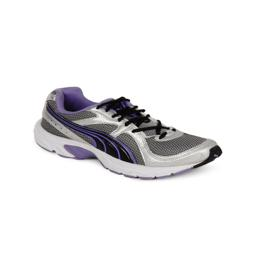

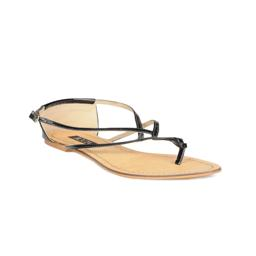

In [415]:
# Loop through the top 5 image paths and display each image
for image_path in top_5_similar_images:
    simiar_image = Image.open(image_path)
    display(simiar_image)

### Model 2

In [44]:
def create_siamese_model_2(base_model, input_shape):
    # Input for left and right image vectors
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Pass the left and right inputs through the base model
    left_output = base_model(left_input)
    right_output = base_model(right_input)

    # Calculate the Euclidean distance between the two outputs
    distance = Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([left_output, right_output])
    
    output = Dense(1,activation='sigmoid')(distance)
    # Create the Siamese model
    siamese_model = Model(inputs=[left_input, right_input], outputs=output)

    return siamese_model

In [45]:
siamese_model_2 = create_siamese_model_2(base_network,(256,256,3))

In [46]:
siamese_model_2.compile(loss=contrastive_loss,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [47]:
siamese_model_2.fit(
    custom_data_generator(train_generator, num_classes, num_pairs_per_batch),
    steps_per_epoch=train_num_batches_per_epoch,
    validation_data=custom_data_generator(val_generator, num_classes, num_pairs_per_batch),
    validation_steps=val_num_batches_per_epoch,  
    epochs=3
)


Epoch 1/3
11/11 [==============================] - 1568s 140s/step - loss: 0.2515 - accuracy: 0.5008 - auc: 0.4939 - precision: 0.4405 - recall: 0.0132 - val_loss: 0.2499 - val_accuracy: 0.5031 - val_auc: 0.5037 - val_precision: 0.4737 - val_recall: 0.0841
Epoch 2/3
11/11 [==============================] - 1469s 135s/step - loss: 0.2501 - accuracy: 0.5026 - auc: 0.4946 - precision: 0.5030 - recall: 0.0744 - val_loss: 0.2501 - val_accuracy: 0.4890 - val_auc: 0.4947 - val_precision: 0.4875 - val_recall: 0.2152
Epoch 3/3
11/11 [==============================] - 1377s 127s/step - loss: 0.2500 - accuracy: 0.4972 - auc: 0.5017 - precision: 0.4985 - recall: 0.2099 - val_loss: 0.2500 - val_accuracy: 0.5100 - val_auc: 0.4959 - val_precision: 0.5071 - val_recall: 0.2392


#### Save model and history

In [48]:
siamese_model_2.save('siamese_model_2_3epoch.h5')

In [49]:
history_siamese_model_2 = siamese_model_2.history

In [50]:
hdf5storage.savemat("history_siamese_model_2_3epoch.h5", history_siamese_model_2.history)

In [51]:
siamese_model_2_loaded = load_model('siamese_model_2_3epoch.h5', custom_objects={'contrastive_loss': contrastive_loss})

In [52]:
history_siamese_model_2_loaded= hdf5storage.loadmat("history_siamese_model_2_3epoch.h5",custom_objects={'contrastive_loss': contrastive_loss})

### Model 3 - VGG16

In [9]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.01

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [10]:
# Function to create VGG16 base model
def base_model_vgg16(input_shape):
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the weights of the VGG16 layers
    for layer in vgg16_model.layers[-2:]:
        layer.trainable = True
    
    return vgg16_model



In [11]:


def contrastive_loss2(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [12]:
# Function to build the siamese model
def build_siamese_model(input_shape):
    # Create the VGG16 base model
    vgg16_base_model = base_model_vgg16(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = vgg16_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Process the second image through the VGG16 base model
    x2 = vgg16_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [13]:
siamese_vgg16_model = build_siamese_model((256,256,3))

In [14]:
siamese_vgg16_model.compile(loss=contrastive_loss2,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
history_siamese_vgg16_model = siamese_vgg16_model.fit(custom_data_generator(train_generator, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=3
)

Epoch 1/3


### Model 4 - Resnet50

In [35]:
# Define the batch size and number of pairs per batch
batch_size = 64
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.01

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [36]:
# Function to create Resnet50 base model
def base_model_resnet50(input_shape):
    base_resnet50_model = ResNet50(include_top=False,weights = 'imagenet',input_shape=input_shape)
    for layers in base_resnet50_model.layers:
          layers.trainable = False
    return base_resnet50_model

In [37]:
def contrastive_loss2(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [38]:
# Function to build the siamese model
def build_siamese_model_resnet50(input_shape):
    # Create the VGG16 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [39]:
siamese_resnet50_model = build_siamese_model_resnet50((256,256,3))

In [40]:
siamese_resnet50_model.compile(loss=contrastive_loss2,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [41]:
history_siamese_resnet50_model = siamese_resnet50_model.fit(custom_data_generator(train_generator, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=5
)

Epoch 1/5
2/2 [==============================] - 421s 234s/step - loss: 7207.1309 - accuracy: 0.4780 - auc: 0.5000 - precision: 0.4780 - recall: 1.0000
Epoch 2/5
2/2 [==============================] - 411s 195s/step - loss: 516.0061 - accuracy: 0.5022 - auc: 0.5022 - precision: 0.5064 - recall: 0.5019
Epoch 3/5
2/2 [==============================] - 435s 215s/step - loss: 22.4718 - accuracy: 0.5112 - auc: 0.5115 - precision: 0.5268 - recall: 0.5114
Epoch 4/5
2/2 [==============================] - 463s 258s/step - loss: 4.1578 - accuracy: 0.4893 - auc: 0.4895 - precision: 0.4893 - recall: 0.4893
Epoch 5/5
2/2 [==============================] - 409s 200s/step - loss: 15.2027 - accuracy: 0.5066 - auc: 0.5068 - precision: 0.5054 - recall: 0.5064


### Model 4

In [116]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'

image_size = (256, 256)
num_classes = 10

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
 
val_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the val set

test_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the test set


train_generator_batch32 = train_datagen.flow_from_directory(directory=train_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator_batch32 = val_datagen.flow_from_directory(directory=val_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                shuffle=True,
                                                  classes=[str(i) for i in range(num_classes)])

test_generator_batch32 = test_datagen.flow_from_directory(directory=test_data_dir, target_size = image_size,
                                                    class_mode='categorical',
                                                   batch_size=32,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])

Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


In [117]:
def create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch):
    pairs = []
    labels = []

    for _ in range(num_pairs_per_batch):
        # Generate a batch of images and their corresponding labels
        batch_images, batch_labels = data_generator.next()

        # Split the batch into two halves (left and right images)
        batch_size = len(batch_images)
        half_batch_size = batch_size // 2
        left_images = batch_images[:half_batch_size]
        right_images = batch_images[half_batch_size:]

        # Create positive and negative pairs within the batch
        for i in range(half_batch_size):
            img1 = left_images[i]
            img2 = right_images[i]
            label1 = batch_labels[i]
            label2 = batch_labels[i + half_batch_size]

            # Determine if the images belong to the same class (positive pair) or different classes (negative pair)
            same_class = np.random.randint(0, 2)
            if same_class == 1:
                label = 1  # Positive pair
            else:
                label = 0  # Negative pair

            pairs.append([img1, img2])
            labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels


In [118]:
def contrastive_loss05(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


In [119]:
def euclid_dis(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=-1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [120]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.05

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [121]:
# Function to create Resnet50 base model
def base_model_resnet50(input_shape):
    base_resnet50_model = ResNet50(include_top=False,weights = 'imagenet',input_shape=input_shape)
    for layers in base_resnet50_model.layers:
          layers.trainable = False
    return base_resnet50_model

In [122]:
# Function to build the siamese model
def build_siamese_model_resnet50(input_shape):
    # Create the Resnet50 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [123]:
train_pair_gen = custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch)

In [124]:
batch_pairs, batch_labels = next(train_pair_gen)

In [125]:
len(batch_pairs[0])

256

In [126]:
len(batch_labels)

256

In [127]:
num_positive_pairs = num_classes * (batch_size // num_classes)
num_positive_pairs

30

In [128]:
num_negative_pairs = batch_size * (num_classes - 1)
num_negative_pairs

288

In [129]:
siamese_resnet50_model_batch32 = build_siamese_model_resnet50((256,256,3))

In [130]:
siamese_resnet50_model_batch32.compile(loss=contrastive_loss05,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [131]:
history_siamese_resnet50_model_batch32 = siamese_resnet50_model_batch32.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
)

Epoch 1/10
11/11 [==============================] - 257s 24s/step - loss: 1319.1847 - accuracy: 0.5060 - auc: 0.5069 - precision: 0.5168 - recall: 0.4616 - val_loss: 0.1217 - val_accuracy: 0.5117 - val_auc: 0.5027 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 2/10
11/11 [==============================] - 248s 23s/step - loss: 6.3627 - accuracy: 0.5110 - auc: 0.5090 - precision: 0.5244 - recall: 0.1919 - val_loss: 0.1311 - val_accuracy: 0.4753 - val_auc: 0.4986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 236s 22s/step - loss: 0.1282 - accuracy: 0.4863 - auc: 0.5003 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 53.1161 - val_accuracy: 0.4648 - val_auc: 0.5000 - val_precision: 0.4648 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 235s 22s/step - loss: 6.6040 - accuracy: 0.5213 - auc: 0.5114 - precision: 0.5156 - recall: 0.1935 - val_loss: 0.1145 - val_accuracy: 0.5417 - val_auc: 0.4988 -

In [67]:
train_num_batches_per_epoch

11

In [69]:
train_num_pairs_to_use

184

### Model 5'; Reducing learning rate:

In [192]:
# Directory path
train_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Train'
val_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Validation'
test_data_dir = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Capstone_fashion_label_classification_from_images/Data/Train_Test_Validation/Test'

image_size = (256, 256)
num_classes = 10

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
 
val_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the val set

test_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the test set


train_generator_batch32 = train_datagen.flow_from_directory(directory=train_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator_batch32 = val_datagen.flow_from_directory(directory=val_data_dir, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                shuffle=True,
                                                  classes=[str(i) for i in range(num_classes)])

test_generator_batch32 = test_datagen.flow_from_directory(directory=test_data_dir, target_size = image_size,
                                                    class_mode='categorical',
                                                   batch_size=32,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])

Found 14782 images belonging to 10 classes.
Found 4935 images belonging to 10 classes.
Found 4926 images belonging to 10 classes.


In [193]:
def create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch):
    pairs = []
    labels = []

    for _ in range(num_pairs_per_batch):
        # Generate a batch of images and their corresponding labels
        batch_images, batch_labels = data_generator.next()

        # Split the batch into two halves (left and right images)
        batch_size = len(batch_images)
        half_batch_size = batch_size // 2
        left_images = batch_images[:half_batch_size]
        right_images = batch_images[half_batch_size:]

        # Create positive and negative pairs within the batch
        for i in range(half_batch_size):
            img1 = left_images[i]
            img2 = right_images[i]
            label1 = batch_labels[i]
            label2 = batch_labels[i + half_batch_size]

            # Determine if the images belong to the same class (positive pair) or different classes (negative pair)
            same_class = np.random.randint(0, 2)
            if same_class == 1:
                label = 1  # Positive pair
            else:
                label = 0  # Negative pair

            pairs.append([img1, img2])
            labels.append(label)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels


In [194]:
def contrastive_loss05(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


In [195]:
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [196]:
siamese_resnet50_model_batch32_lr = build_siamese_model_resnet50((256,256,3))

In [197]:
siamese_resnet50_model_batch32_lr.compile(loss=contrastive_loss05,optimizer=opt,
                  metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
history_siamese_resnet50_model_batch32_lr = siamese_resnet50_model_batch32_lr.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
) 

Epoch 1/10
11/11 [==============================] - 245s 23s/step - loss: 342.3020 - accuracy: 0.4904 - auc: 0.4923 - precision: 0.4805 - recall: 0.5367 - val_loss: 0.1371 - val_accuracy: 0.4492 - val_auc: 0.5015 - val_precision: 1.0000 - val_recall: 0.0024
Epoch 2/10
11/11 [==============================] - 240s 22s/step - loss: 1.0113 - accuracy: 0.5021 - auc: 0.4998 - precision: 0.4980 - recall: 0.1821 - val_loss: 0.1333 - val_accuracy: 0.4661 - val_auc: 0.5010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 240s 22s/step - loss: 1.4981 - accuracy: 0.4934 - auc: 0.4964 - precision: 0.4922 - recall: 0.1777 - val_loss: 4.4101 - val_accuracy: 0.4870 - val_auc: 0.5000 - val_precision: 0.4870 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 236s 22s/step - loss: 2.9182 - accuracy: 0.4996 - auc: 0.4970 - precision: 0.4896 - recall: 0.2699 - val_loss: 0.1206 - val_accuracy: 0.5169 - val_auc: 0.4987 - val_preci

### Model 5'', margin 0.5, learning rate 0.0005, 30% of train data

In [ ]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.3

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [ ]:
def contrastive_loss05(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [ ]:
siamese_resnet50_bat32_lr00005_30train = build_siamese_model_resnet50((256,256,3))

In [ ]:
siamese_resnet50_bat32_lr00005_30train.compile(loss=contrastive_loss05,optimizer=opt,
                  metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
history_siamese_resnet50_bat32_lr00005_30train = siamese_resnet50_bat32_lr00005_30train.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
) 

### Model 5

In [138]:
def contrastive_loss03(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.3
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)


In [139]:
siamese_resnet50_model_batch32_loss03 = build_siamese_model_resnet50((256,256,3))

In [140]:
siamese_resnet50_model_batch32_loss03.compile(loss=contrastive_loss03,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [141]:
history_siamese_resnet50_batch32_loss03 = siamese_resnet50_model_batch32_loss03.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
)

Epoch 1/10
11/11 [==============================] - 253s 23s/step - loss: 1140.1646 - accuracy: 0.4986 - auc: 0.4994 - precision: 0.4961 - recall: 0.6359 - val_loss: 0.0481 - val_accuracy: 0.4635 - val_auc: 0.4998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 243s 23s/step - loss: 1.9604 - accuracy: 0.5000 - auc: 0.4990 - precision: 0.5019 - recall: 0.0916 - val_loss: 0.0451 - val_accuracy: 0.4980 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 232s 22s/step - loss: 0.0460 - accuracy: 0.4881 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 52.2518 - val_accuracy: 0.4779 - val_auc: 0.5000 - val_precision: 0.4779 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 234s 22s/step - loss: 4.2186 - accuracy: 0.5135 - auc: 0.5059 - precision: 0.5234 - recall: 0.0970 - val_loss: 0.0440 - val_accuracy: 0.5099 - val_auc: 

### Model 6

In [142]:
def contrastive_loss01(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [143]:
siamese_resnet50_model_batch32_loss01 = build_siamese_model_resnet50((256,256,3))

In [144]:
siamese_resnet50_model_batch32_loss01.compile(loss=contrastive_loss01,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [145]:
history_siamese_resnet50_batch32_loss01 = siamese_resnet50_model_batch32_loss01.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10
)

Epoch 1/10
11/11 [==============================] - 241s 22s/step - loss: 1245.0192 - accuracy: 0.5027 - auc: 0.5036 - precision: 0.5083 - recall: 0.3670 - val_loss: 0.0049 - val_accuracy: 0.5091 - val_auc: 0.4963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 230s 21s/step - loss: 0.0049 - accuracy: 0.5089 - auc: 0.5008 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.4781 - val_auc: 0.5023 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 232s 22s/step - loss: 7.2944 - accuracy: 0.4764 - auc: 0.4913 - precision: 0.5000 - recall: 0.1737 - val_loss: 62.8387 - val_accuracy: 0.4948 - val_auc: 0.5000 - val_precision: 0.4948 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 230s 21s/step - loss: 10.6421 - accuracy: 0.5011 - auc: 0.5002 - precision: 0.4980 - recall: 0.1818 - val_loss: 84.2778 - val_accuracy: 0.4848 - val_auc

### Model 7

In [150]:
# Function to build the siamese model
def build_siamese_model_resnet50_reg(input_shape):
    # Create the Resnet50 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu',kernel_regularizer=L2(0.005))(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=L2(0.005))(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [151]:
siamese_resnet50_model_batch32_reg = build_siamese_model_resnet50_reg((256,256,3))

In [152]:
siamese_resnet50_model_batch32_reg.compile(loss=contrastive_loss03,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [153]:
history_siamese_resnet50_model_batch32_reg = siamese_resnet50_model_batch32_reg.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10)

Epoch 1/10
11/11 [==============================] - 247s 23s/step - loss: 1108.1035 - accuracy: 0.4963 - auc: 0.4980 - precision: 0.5020 - recall: 0.6309 - val_loss: 0.8522 - val_accuracy: 0.4792 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
11/11 [==============================] - 233s 22s/step - loss: 0.8347 - accuracy: 0.4993 - auc: 0.4963 - precision: 0.4724 - recall: 0.0860 - val_loss: 0.7905 - val_accuracy: 0.4688 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 232s 22s/step - loss: 11.9101 - accuracy: 0.5025 - auc: 0.5089 - precision: 0.5156 - recall: 0.1870 - val_loss: 0.7971 - val_accuracy: 0.4818 - val_auc: 0.5028 - val_precision: 0.3077 - val_recall: 0.0102
Epoch 4/10
11/11 [==============================] - 228s 21s/step - loss: 3.4254 - accuracy: 0.5030 - auc: 0.4945 - precision: 0.4961 - recall: 0.0909 - val_loss: 0.7856 - val_accuracy: 0.5195 - val_auc: 0.5000 -

### Model 8: increase margin to 1.5

In [185]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.05

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [186]:
def contrastive_loss15(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 1.5
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [187]:
# Function to build the siamese model
def build_siamese_model_resnet50_reg(input_shape):
    # Create the Resnet50 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [188]:
siamese_resnet50_model_batch32_loss15 = build_siamese_model_resnet50((256,256,3))

In [189]:
siamese_resnet50_model_batch32_loss15.compile(loss=contrastive_loss03,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [190]:
history_siamese_resnet50_model_batch32_loss15 = siamese_resnet50_model_batch32_loss15.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10)

Epoch 1/10
11/11 [==============================] - 408s 37s/step - loss: 1236.2583 - accuracy: 0.4984 - auc: 0.4954 - precision: 0.5026 - recall: 0.5486 - val_loss: 0.0438 - val_accuracy: 0.5117 - val_auc: 0.5040 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 2/10
11/11 [==============================] - 365s 33s/step - loss: 0.0438 - accuracy: 0.5135 - auc: 0.4979 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0470 - val_accuracy: 0.4768 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 [==============================] - 258s 24s/step - loss: 7.1681 - accuracy: 0.5110 - auc: 0.5085 - precision: 0.5156 - recall: 0.1895 - val_loss: 0.0446 - val_accuracy: 0.5026 - val_auc: 0.5013 - val_precision: 1.0000 - val_recall: 0.0026
Epoch 4/10
11/11 [==============================] - 248s 23s/step - loss: 11.5144 - accuracy: 0.5023 - auc: 0.5049 - precision: 0.5176 - recall: 0.1868 - val_loss: 35.8667 - val_accuracy: 0.4993 - val_auc: 0.5000 

256

### Model 9 - margin 0.3 + new balanced dataset

In [154]:
def contrastive_loss03(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.3
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [155]:
# Directory path

train_bl = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Balance_Class/Train'
val_bl = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Balance_Class/Validation'
test_bl = '/Users/thaophan/Documents/Flatiron/Phase5_Project/Balance_Class/Test'

image_size = (256, 256)
num_classes = 10

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)
 
val_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the val set

test_datagen = ImageDataGenerator(rescale = 1/255) # Only rescale for the test set


train_generator_b32_bl = train_datagen.flow_from_directory(directory=train_bl, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    classes=[str(i) for i in range(num_classes)])

val_generator_b32_bl = val_datagen.flow_from_directory(directory=val_bl, target_size = image_size,
                                                   class_mode='categorical',
                                                    batch_size=32,
                                                shuffle=True,
                                                  classes=[str(i) for i in range(num_classes)])

test_generator_b32_bl = test_datagen.flow_from_directory(directory=test_bl, target_size = image_size,
                                                    class_mode='categorical',
                                                   batch_size=32,
                                                  shuffle=False,
                                                  classes=[str(i) for i in range(num_classes)])

Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [156]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator_b32_bl) * num_pairs_per_batch
total_validation_pairs = len(val_generator_b32_bl) * num_pairs_per_batch
total_test_pairs = len(test_generator_b32_bl) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 1

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [157]:
siamese_resnet50_b32_loss03_bl = build_siamese_model_resnet50((256,256,3))

In [158]:
siamese_resnet50_b32_loss03_bl.compile(loss=contrastive_loss03,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [160]:
history_siamese_resnet50_b32_loss03_bl = siamese_resnet50_b32_loss03_bl.fit(custom_data_generator(train_generator_b32_bl, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_b32_bl, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=10)

Epoch 1/10
32/32 [==============================] - 798s 25s/step - loss: 388.9188 - accuracy: 0.4950 - auc: 0.4964 - precision: 0.4952 - recall: 0.2437 - val_loss: 29.8049 - val_accuracy: 0.4983 - val_auc: 0.5000 - val_precision: 0.4983 - val_recall: 1.0000
Epoch 2/10
32/32 [==============================] - 791s 25s/step - loss: 3.7424 - accuracy: 0.5060 - auc: 0.5030 - precision: 0.5195 - recall: 0.0670 - val_loss: 0.0452 - val_accuracy: 0.4958 - val_auc: 0.5005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 801s 25s/step - loss: 3.0901 - accuracy: 0.4900 - auc: 0.4989 - precision: 0.4918 - recall: 0.0294 - val_loss: 0.0443 - val_accuracy: 0.5060 - val_auc: 0.5015 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 805s 25s/step - loss: 0.0442 - accuracy: 0.5076 - auc: 0.4999 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0461 - val_accuracy: 0.4860 - val_auc: 0

### Model 9, margin = 0.1

In [163]:
# Function to build the siamese model
def build_siamese_model_resnet50_reg(input_shape):
    # Create the Resnet50 base model
    resnet50_base_model = base_model_resnet50(input_shape)
    
    # Inputs for the two images
    input_image1 = Input(shape=input_shape)
    input_image2 = Input(shape=input_shape)
    
    # Process the first image through the VGG16 base model
    x1 = resnet50_base_model(input_image1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # Process the second image through the VGG16 base model
    x2 = resnet50_base_model(input_image2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # Compute the Euclidean distance between the two image embeddings
    distance =Lambda(euclid_dis, output_shape=eucl_dist_output_shape)([x1, x2])
    
    # Create the siamese model
    siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)
    
    return siamese_model

In [164]:
def contrastive_loss01(y_true, y_pred):
    """Calculates the contrastive loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing contrastive loss as floating point value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    margin  = 0.1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square)

In [165]:
# Define the batch size and number of pairs per batch
batch_size = 32
num_pairs_per_batch = batch_size // 2  # Create half positive and half negative pairs in each batch
# Determine the total number of training, validation, and test pairs
total_training_pairs = len(train_generator) * num_pairs_per_batch
total_validation_pairs = len(val_generator) * num_pairs_per_batch
total_test_pairs = len(test_generator) * num_pairs_per_batch

# Define the percentage of training, validation, and test pairs to use in each epoch
percentage_to_use = 0.05

# Calculate the number of training and validation pairs to use in each epoch
train_num_pairs_to_use = int(total_training_pairs * percentage_to_use)
val_num_pairs_to_use = int(total_validation_pairs * percentage_to_use)
test_num_pairs_to_use = int(total_test_pairs * percentage_to_use)


# Calculate the number of batches in each epoch
train_num_batches_per_epoch = train_num_pairs_to_use // num_pairs_per_batch
val_num_batches_per_epoch = val_num_pairs_to_use // num_pairs_per_batch
test_num_batches_per_epoch = test_num_pairs_to_use // num_pairs_per_batch

#Define a function to get image pairs from train and validation generator
def custom_data_generator(data_generator, num_classes, num_pairs_per_batch):
    while True:
        # Create pairs and labels for the current batch
        pairs, labels = create_siamese_pairs(data_generator, num_classes, num_pairs_per_batch)
        yield [pairs[:, 0], pairs[:, 1]], labels

In [166]:
siamese_resnet50_b32_loss01 = build_siamese_model_resnet50((256,256,3))

In [167]:
siamese_resnet50_b32_loss01.compile(loss=contrastive_loss01,optimizer='Adam',
                  metrics=['accuracy','AUC','Precision','Recall'])

In [168]:
history_siamese_resnet50_model_batch32_loss01 = siamese_resnet50_b32_loss01.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                            steps_per_epoch=train_num_batches_per_epoch,
                            validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                            validation_steps=val_num_batches_per_epoch,
                            epochs=5)

Epoch 1/5
11/11 [==============================] - 269s 25s/step - loss: 1294.0399 - accuracy: 0.4977 - auc: 0.4999 - precision: 0.5175 - recall: 0.4551 - val_loss: 31.5411 - val_accuracy: 0.5260 - val_auc: 0.5000 - val_precision: 0.5260 - val_recall: 1.0000
Epoch 2/5
11/11 [==============================] - 256s 24s/step - loss: 7.8513 - accuracy: 0.5046 - auc: 0.5085 - precision: 0.5283 - recall: 0.1903 - val_loss: 0.0050 - val_accuracy: 0.4948 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
11/11 [==============================] - 247s 23s/step - loss: 3.0400 - accuracy: 0.4947 - auc: 0.4968 - precision: 0.4961 - recall: 0.0894 - val_loss: 0.0048 - val_accuracy: 0.5152 - val_auc: 0.5014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
11/11 [==============================] - 250s 23s/step - loss: 0.0050 - accuracy: 0.5005 - auc: 0.4996 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.5339 - val_auc: 0.50

### Model 11

In [174]:
from tensorflow.keras.losses import BinaryCrossentropy


def binary_cross_entropy_loss(y_true, y_pred):
    """Calculates the binary cross-entropy loss.

    Arguments:
        y_true: List of labels, each label is of type float32.
        y_pred: List of predictions of same length as of y_true,
                each label is of type float32.

    Returns:
        A tensor containing binary cross-entropy loss as a floating point value.
    """
    return BinaryCrossentropy(from_logits=False)(y_true, y_pred)


In [175]:
siamese_resnet50_b32_binaloss = build_siamese_model_resnet50((256,256,3))


In [176]:
siamese_resnet50_b32_binaloss.compile(loss=binary_cross_entropy_loss,
                                      optimizer='Adam',
                                      metrics=['accuracy','AUC','Precision','Recall'])


In [177]:
history_siamese_resnet50_b32_binaloss = siamese_resnet50_b32_binaloss.fit(custom_data_generator(train_generator_batch32, num_classes, num_pairs_per_batch),
                                                                                   steps_per_epoch=train_num_batches_per_epoch,
                                                                                   validation_data=custom_data_generator(val_generator_batch32, num_classes, num_pairs_per_batch),
                                                                                   validation_steps=val_num_batches_per_epoch,
                                                                                   epochs=10)


Epoch 1/10
11/11 [==============================] - 256s 23s/step - loss: 7.4594 - accuracy: 0.5108 - auc: 0.5000 - precision: 0.5108 - recall: 1.0000 - val_loss: 8.0217 - val_accuracy: 0.4740 - val_auc: 0.5000 - val_precision: 0.4740 - val_recall: 1.0000
Epoch 2/10
11/11 [==============================] - 250s 23s/step - loss: 7.4243 - accuracy: 0.5131 - auc: 0.5000 - precision: 0.5131 - recall: 1.0000 - val_loss: 7.3721 - val_accuracy: 0.5166 - val_auc: 0.5000 - val_precision: 0.5166 - val_recall: 1.0000
Epoch 3/10
11/11 [==============================] - 250s 23s/step - loss: 7.8250 - accuracy: 0.4869 - auc: 0.5000 - precision: 0.4869 - recall: 1.0000 - val_loss: 7.2076 - val_accuracy: 0.5273 - val_auc: 0.5000 - val_precision: 0.5273 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 246s 23s/step - loss: 7.3619 - accuracy: 0.5172 - auc: 0.5000 - precision: 0.5172 - recall: 1.0000 - val_loss: 7.4731 - val_accuracy: 0.5099 - val_auc: 0.5000 - val_precision: 0.50